## 네이버 리뷰 감성 분류하기

In [2]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.8 MB/s eta 0:00:00


In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 불러오기

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b9e448dbee0>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [8]:
len(test_data)

50000

### 데이터 정제하기

In [9]:
train_data = train_data.head(50000)
test_data = test_data.head(10000)

In [10]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
len(train_data)

49121

<Axes: >

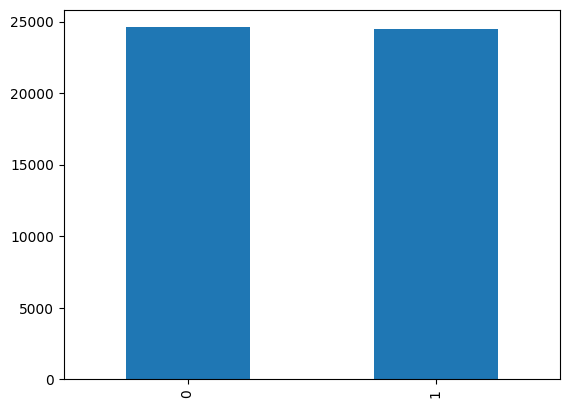

In [12]:
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data.isnull().values.any())

True


In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [16]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].apply(lambda x: re.sub("[^가-힣 ]", "", str(x)))
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    365
label         0
dtype: int64


<ipython-input-17-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [18]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

48755


In [19]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].apply(lambda x: re.sub("[^가-힣 ]", "", str(x)))
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 9912


<ipython-input-19-73582b85c4de>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


### 토큰화

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [21]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [22]:
list = okt.pos('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', norm=True)
list

[('와', 'Verb'),
 ('이런', 'Adjective'),
 ('것', 'Noun'),
 ('도', 'Josa'),
 ('영화', 'Noun'),
 ('라고', 'Josa'),
 ('차라리', 'Noun'),
 ('뮤직비디오', 'Noun'),
 ('를', 'Josa'),
 ('만드는', 'Verb'),
 ('게', 'Noun'),
 ('나을', 'Verb'),
 ('뻔', 'Noun')]

In [23]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.pos(sentence, norm=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    josa_removed_sentence = [word for word in stopwords_removed_sentence if word[1] != 'Josa']
    X_train.append(josa_removed_sentence)

100%|██████████| 48755/48755 [06:43<00:00, 120.68it/s]


In [24]:
print(X_train[:3])

[[('아', 'Exclamation'), ('더빙', 'Noun'), ('진짜', 'Noun'), ('짜증나네요', 'Adjective'), ('목소리', 'Noun')], [('흠', 'Noun'), ('포스터', 'Noun'), ('보고', 'Noun'), ('초딩', 'Noun'), ('영화', 'Noun'), ('줄', 'Noun'), ('오버', 'Noun'), ('연기', 'Noun'), ('가볍지', 'Adjective'), ('않구나', 'Verb')], [('너', 'Modifier'), ('무재', 'Noun'), ('밓었', 'Noun'), ('다그', 'Noun'), ('래서', 'Noun'), ('보는것을', 'Verb'), ('추천', 'Noun'), ('다', 'Adverb')]]


In [25]:
X_new_train = []
for sentence in X_train:
    temp = []
    for word in sentence:
        temp.append(word[0])
    X_new_train.append(temp)
X_new_train[:3]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍지', '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '다']]

In [48]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.pos(sentence, norm=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    josa_removed_sentence = [word for word in stopwords_removed_sentence if word[1] != 'Josa']
    X_test.append(stopwords_removed_sentence)

100%|██████████| 9912/9912 [01:15<00:00, 130.97it/s]


In [49]:
X_new_test = []
for sentence in X_test:
    temp = []
    for word in sentence:
        temp.append(word[0])
    X_new_test.append(temp)
X_new_test[:3]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '....',
  '나쁘진',
  '않지만',
  '10',
  '점',
  '짜',
  '리',
  '는',
  '더',
  '더욱',
  '아니잖아']]

### 정수 인코딩

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_new_train)

In [51]:
print(tokenizer.word_index)

{'영화': 1, '이': 2, '들': 3, '너무': 4, '정말': 5, '것': 6, '적': 7, '진짜': 8, '점': 9, '평점': 10, '연기': 11, '내': 12, '최고': 13, '잘': 14, '그': 15, '안': 16, '이런': 17, '왜': 18, '생각': 19, '스토리': 20, '못': 21, '한': 22, '드라마': 23, '다': 24, '감동': 25, '사람': 26, '보고': 27, '하는': 28, '더': 29, '말': 30, '때': 31, '감독': 32, '배우': 33, '그냥': 34, '거': 35, '본': 36, '재미': 37, '뭐': 38, '시간': 39, '내용': 40, '중': 41, '없는': 42, '좀': 43, '수': 44, '쓰레기': 45, '작품': 46, '없다': 47, '사랑': 48, '봤는데': 49, '할': 50, '볼': 51, '나': 52, '다시': 53, '마지막': 54, '하나': 55, '이렇게': 56, '아': 57, '정도': 58, '같은': 59, '저': 60, '좋은': 61, '처음': 62, '있는': 63, '완전': 64, '입니다': 65, '장면': 66, '액션': 67, '주인공': 68, '걸': 69, '개': 70, '보는': 71, '돈': 72, '최악': 73, '하': 74, '느낌': 75, '재밌게': 76, '기': 77, '참': 78, '지금': 79, '역시': 80, '없고': 81, '이야기': 82, '끝': 83, '봐도': 84, '임': 85, '연출': 86, '년': 87, '별로': 88, '네': 89, '별': 90, '많이': 91, '명작': 92, '듯': 93, '그리고': 94, '대': 95, '만': 96, '또': 97, '이영화': 98, '일': 99, '보면': 100, '이해': 101, '분': 102, '해서': 103, '때문': 

In [52]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 53490
등장 빈도가 2번 이하인 희귀 단어의 수: 37551
단어 집합에서 희귀 단어의 비율: 70.2019068984857
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.799517007642805


In [53]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 15940


In [54]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_new_train)
X_train = tokenizer.texts_to_sequences(X_new_train)
X_test = tokenizer.texts_to_sequences(X_new_test)

In [55]:
print(X_train[:3])

[[57, 341, 8, 6834, 633], [919, 379, 27, 508, 1, 142, 1550, 11, 5237], [317, 3115, 5238, 7643, 161, 24]]


In [56]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플(empty samples) 제거

In [57]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [58]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

48496
48496


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩

리뷰의 최대 길이 : 56
리뷰의 평균 길이 : 9.593822170900692


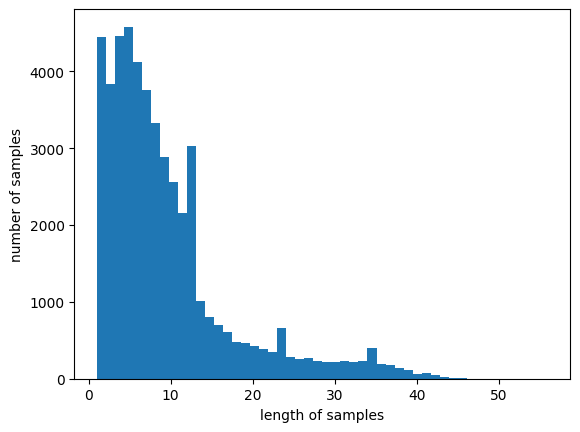

In [59]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [60]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [61]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.97698779280765


In [62]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### LSTM으로 네이버 영화 리뷰 감성 분류하기

In [63]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
607/607 [==============================] - ETA: 0s - loss: 0.4864 - acc: 0.7535
Epoch 1: val_acc improved from -inf to 0.81732, saving model to best_model.h5
607/607 [==============================] - 34s 50ms/step - loss: 0.4864 - acc: 0.7535 - val_loss: 0.4041 - val_acc: 0.8173
Epoch 2/15
607/607 [==============================] - ETA: 0s - loss: 0.3540 - acc: 0.8471
Epoch 2: val_acc improved from 0.81732 to 0.82887, saving model to best_model.h5
607/607 [==============================] - 11s 19ms/step - loss: 0.3540 - acc: 0.8471 - val_loss: 0.3839 - val_acc: 0.8289
Epoch 3/15
607/607 [==============================] - ETA: 0s - loss: 0.3157 - acc: 0.8689
Epoch 3: val_acc improved from 0.82887 to 0.83062, saving model to best_model.h5
607/607 [==============================] - 9s 14ms/step - loss: 0.3157 - acc: 0.8689 - val_loss: 0.3891 - val_acc: 0.8306
Epoch 4/15
607/607 [==============================] - ETA: 0s - loss: 0.2896 - acc: 0.8813
Epoch 4: val_acc did not imp

In [64]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

310/310 [==============================] - 2s 4ms/step - loss: 0.4020 - acc: 0.8241

 테스트 정확도: 0.8241


train 데이터의 크기를 1/3으로 줄였음에도 불구하고 정확도가 원래도 3%p 밖에 떨어지지 않았다.   
따라서 조사를 없앤 전처리가 꽤 효과적이었음을 알 수 있다.

In [65]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### 리뷰 예측해보기

In [76]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [77]:
sentiment_predict('이런걸 돈주고 왜보냐?')

1/1 [==============================] - 0s 22ms/step
97.78% 확률로 부정 리뷰입니다.



In [78]:
sentiment_predict('재밌는것 같기도 하고 재미없는것 같기도 하고')

1/1 [==============================] - 0s 22ms/step
64.63% 확률로 부정 리뷰입니다.



In [79]:
sentiment_predict('애매하다')

1/1 [==============================] - 0s 38ms/step
80.45% 확률로 부정 리뷰입니다.

